# Part 1/N - Tracking larval zebrafish

This is a short introduction...
Today we will

    1) Load the video
    2) Learn what thresholding is
    3) Use image moments to track the fish

$$L(x) = \frac{1}{N}\sum_i^N(y_i-x_i)^2$$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import imageio as io

In [3]:
ims = io.mimread("zebrafish.mp4", memtest=False)

uint8, 8 bit 2**8 --> 0...255

Multidimensional array TxHxWxC

In [52]:
ims = np.asarray(ims)

In [53]:
ims.shape

(2500, 488, 648, 3)

# Way 1 to get rid of extra channels --> Take 1

In [22]:
way1 = ims[..., 0]

# Way 2 to get rid... -> Mean BAD!!!

In [ ]:
uint8 8 bit 
(1 + 1 + 1)/3 = 1.0 --> 64 bit( !!!!!!!!!!)

In [23]:
way2 = ims.mean(3)

In [25]:
way2.dtype

dtype('float64')

# Way 3 - the right way!!

!! NOT: (R+G+B)/3

!! Weighted average, see online help

In [26]:
from skimage.color import rgb2gray

In [ ]:
rgb2gray(ims)

# Get only the first channel!
# And, get rid of the black rim! By cropping the image

In [54]:
ims = ims[:, 4:-4, 4:-4, 0]

In [55]:
ims.shape

(2500, 480, 640)

# We stick to way1

(-0.5, 639.5, 479.5, -0.5)

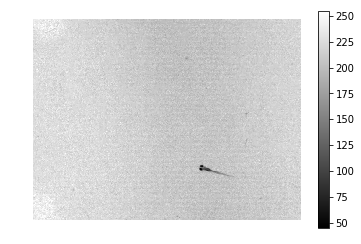

In [56]:
plt.imshow(ims[0], cmap='gray')
plt.colorbar()
plt.axis('off')

In [33]:
im = ims[0]

In [34]:
from ipywidgets import interact

In [37]:
@interact
def threshold(t:(0, 255)):
    plt.imshow((im > t).astype(np.uint8))
    plt.colorbar()

interactive(children=(IntSlider(value=127, description='t', max=255), Output()), _dom_classes=('widget-interact',))

In [42]:
t = 82

In [40]:
@interact
def thresholdOverMovie(frame:(0, ims.shape[0]-1), t:(0, 255)):
    plt.imshow((ims[frame] < t).astype(np.uint8))
    plt.colorbar()

interactive(children=(IntSlider(value=1249, description='frame', max=2499), IntSlider(value=127, description='t', max=255), Output()), _dom_classes=('widget-interact',))

In [41]:
from skimage.measure import moments

In [57]:
im = ims[0]
t = 82 # threshold

$$ M_{p,q} = \sum_x\sum_y x^p \cdot y^q \cdot I(x,y) $$

In [58]:
M = moments(im < 82)

In [59]:
M[0, 0]

41.0

In [62]:
y, x = M[1, 0]/M[0, 0], M[0, 1]/M[0, 0]

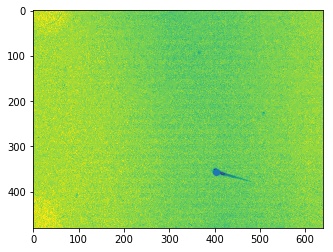

In [63]:
plt.imshow(im)
plt.scatter(x, y)

In [65]:
from tqdm.notebook import tqdm
# Progress bar

In [100]:
from time import time

In [101]:
%%time
im = ims[frame]
# 2) threshold
thresholded_im = im < threshold
# 3) compute position
M = moments(thresholded_im)
y, x = M[1, 0]/M[0, 0], M[0, 1]/M[0, 0]
# 4) append image position
positions[frame] = y, x

Wall time: 4.21 ms


In [74]:
threshold = 82
positions = np.empty((ims.shape[0], 2))

for frame in tqdm(range(ims.shape[0])):
    
    # calculate the positions
    # 1) get image
    im = ims[frame]
    # 2) threshold
    thresholded_im = im < threshold
    # 3) compute position
    M = moments(thresholded_im)
    y, x = M[1, 0]/M[0, 0], M[0, 1]/M[0, 0]
    # 4) append image position
    positions[frame] = y, x

HBox(children=(FloatProgress(value=0.0, max=2500.0), HTML(value='')))

A way to show the meaning behind values

In [69]:
from collections import namedtuple

In [72]:
pos = namedtuple('position', ['x', 'y'])

In [153]:
pos(*positions[frame])

position(x=439.9756097560976, y=510.3658536585366)

In [68]:
positions[frame]

(439.9756097560976, 510.3658536585366)

In [112]:
@interact
def showFrameAndTrace(up_to_frame:(0, ims.shape[0]-1)=0):
    plt.subplot(121)
    plt.imshow(ims[up_to_frame])
    
    plt.subplot(122)
    plt.imshow(np.zeros_like(ims[up_to_frame]))
    plt.plot(*positions[:up_to_frame][:, ::-1].T)
#     plt.axis('equal')
#     plt.xlim([0, 640])
#     plt.ylim([480, 0])
    

interactive(children=(IntSlider(value=0, description='up_to_frame', max=2499), Output()), _dom_classes=('widget-interact',))

In [141]:
from skimage.feature import blob_dog, blob_log, blob_doh

In [149]:
%%time
individual_fish = blob_dog(ims[1905] < threshold, threshold=.25)

Wall time: 697 ms


In [150]:
individual_fish

array([[412.     , 108.     ,   1.6    ],
       [406.     , 104.     ,   1.6    ],
       [140.     , 597.     ,   6.5536 ],
       [  0.     ,  42.     ,  10.48576]])

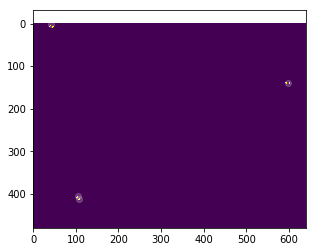

In [151]:
plt.imshow(ims[1905] < threshold)
for fish in individual_fish:
    plt.scatter(fish[1], fish[0], alpha=.2, c='w')